In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from IPython.display import clear_output
import time

In [2]:
from utils import return_board, plot_board, plot_f_pop

# N-Damen-Optimierungsproblem

Das N-Damen-Problem ist ein klassisches Optimierungsproblem, bei dem es darum geht, N Damen auf einem N x N-Schachbrett so zu platzieren, dass sich keine zwei Damen gegenseitig angreifen. Mit anderen Worten, wir wollen eine Anordnung der Damen auf dem Brett finden, bei der sich keine zwei Damen in derselben Reihe, Spalte oder Diagonale befinden. 

Dieses Problem kann als kombinatorisches Optimierungsproblem modelliert werden, bei dem das Ziel darin besteht, die bestmögliche Konfiguration von Königinnen auf dem Brett zu finden. Es gibt viele verschiedene Algorithmen, die zur Lösung des N-Queens-Problems verwendet werden können, darunter genetische Algorithmen, Simulated Annealing und Constraint Programming.

## Binäre Darstellung des N-Queens-Problems

Eine Möglichkeit, die Position der Damen auf dem Brett darzustellen, ist die Verwendung einer binären Kodierung, bei der die Position jeder Dame als binäre Zeichenkette der Länge N dargestellt wird. Im Falle eines 5 x 5 Schachbretts könnte die Position jeder Dame beispielsweise als binäre 5-Bit-Zeichenkette dargestellt werden.

Eine andere Möglichkeit, die Stellung der Damen darzustellen, ist die Verwendung einer Matrix von Binärwerten. In dieser Darstellung ist die Matrix eine quadratische Matrix mit den Abmessungen N x N, und jede Zelle in der Matrix steht für ein Feld auf dem Schachbrett. Ein Wert von 1 in einer bestimmten Zelle bedeutet, dass sich eine Dame auf diesem Feld befindet, während ein Wert von 0 bedeutet, dass das Feld leer ist.

Betrachten Sie zum Beispiel das folgende Array von Damenpositionen:

```python
[0, 3, 1, 4, 2]
```

- Verwenden Sie die Funktion `return_board` für die Umwandlung diese variable in eine binäre Darstellung wie am Beispiel der folgende Matrix:

```python
array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.]])
```

>Diese Matrix stellt eine gültige Lösung des N-Queens-Problems dar, bei der sich keine zwei Königinnen gegenseitig angreifen.

- Verwenden Sie die Funktion `plot_board` , um die Position der "Queens" darzustellen

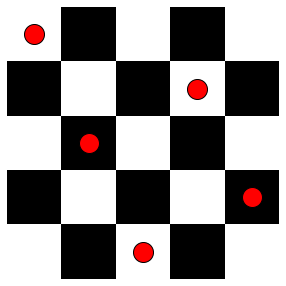

In [3]:
### Solution ###

board_bin = return_board(np.array([0, 3, 1, 4, 2]))
plot_board(board_bin)

# Lösung: Anwendung Evolutionäre Algorithmen (EA)

- Implementieren Sie folgende Funktionen (siehe Referenzen in Vorlesungsfolien), um mit Hilfe von EA das n-Damen Problem zu lösen

In [47]:
def init(n, pop_size):
    """Initializes a population of n-queens configurations."""
    return np.asarray([np.random.permutation(n) for _ in range(pop_size)])

def fitness(individual):
    """Calculates the fitness of an individual n-queens configuration."""
    conflicts = 0
    for i, j in combinations(range(len(individual)), 2):
        if abs(i - j) == abs(individual[i] - individual[j]):
            conflicts += 1
        elif individual[i] == individual[j]:
            conflicts += 1
    return 1 / (conflicts + 1)


def sd_linear(sd, ranking):
    """ Lineares Ranking"""
    lranks = np.asarray(2 - sd + 2* (sd-1) * (np.arange(len(ranking))[::-1]/len(ranking)))
    # normalisieren - sum(lranks) = 1
    return lranks/lranks.sum()

def roulette_selection(pop, f_pop, sd, size):
    """ Rouletteselektion """
    rank = np.argsort(f_pop)
    idx = np.asarray([np.random.choice(len(pop), size=2, p=sd_linear(sd, rank)) for _ in range(size)])
    return pop[idx]


def single_point_cross_over(mother, father):
    """Performs single-point crossover on two parents.
    
    X_mother - erster Elter
    X_father - zweiter Elter 
    
    """
    idx = np.random.randint(0, len(mother))
    child = np.concatenate((mother[:idx], father[idx:]))
    return child

def mutate_int(individual, sigma, m_rate, bounds):
    """Mutates an individual by adding a normally-distributed random number to a random gene."""
    mutated = np.copy(individual)
    for i in range(len(mutated)):
        if np.random.rand() <= m_rate:
            mutated[i] += int(np.round(np.random.normal(0, sigma)))
            mutated[i] = max(bounds[i][0], min(mutated[i], bounds[i][1]))
    return mutated

def reinsertion(population, offspring, f, omega):
    
    """ population - Aktuelle Population
        offspring  - Nachkommen (haengt von gamma ab)
        f          - Fitnessfunktion
        omega      - Wiedereinfuegerate """
    
    f_pop = f(population)
    f_off = f(offspring)
    pop_size = len(population)
    num_reinserted = int(np.round(omega * pop_size))
    idx_reinserted = np.argpartition(f_off, -num_reinserted)[-num_reinserted:]
    new_pop = np.concatenate((population, offspring[idx_reinserted]))
    new_f_pop = np.concatenate((f_pop, f_off[idx_reinserted]))
    sorted_idx = np.argsort(new_f_pop)[::-1]
    
    return new_pop[sorted_idx][:pop_size]
    
f = lambda population : np.asarray([fitness(individuum) for individuum in population])

### Startparameter:

In [53]:
n = 8
max_generation = 100 # Abbruchkriterium
pop_size = 20 # Populationsgroesse
gamma = 1.0 # Generationsluecke
omega = 0.1 # Wiedereinfuegungsrate
sd = 1.4 # Selektionsdruck
p_mutation = 0.4 # Mutationswahrscheinlichkeit
m_rate = 0.8 # Mutationsrate
sigma = 1.2 # Mutationsparameter

pop = init(n, pop_size)
f_pop = f(pop)

## Optimierung für n-Generationen ausführen:

Generation 100: Best fitness = 1.0


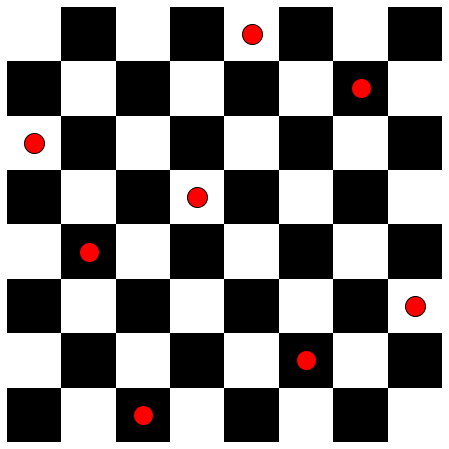

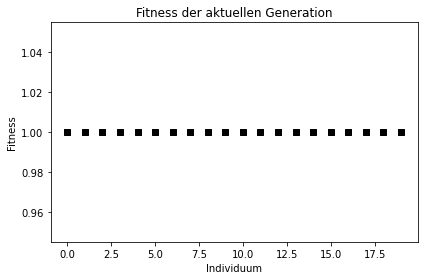

In [54]:
plot_data = [] # Initialize plot data

for i in range(max_generation):
    
    # Selektion
    parents = roulette_selection(pop, f_pop, sd, int(gamma * pop_size))
    
    # Rekombination
    offspring = np.asarray([single_point_cross_over(mother, father) 
                            for father, mother in parents])
    
    # Mutation
    for idx, off in enumerate(offspring):
        if np.random.rand() <= p_mutation:
            # Mutation for ganze Zahlen
            offspring[idx] = mutate_int(off, sigma, m_rate, [[0,n-1]]*n)

    # Wiedereinfuegen
    pop = reinsertion(pop, offspring, f, omega)
    
    # Plot board for best individual
    best_idx = np.argmax(f_pop)
    print(f"Generation {i + 1}: Best fitness = {f_pop[best_idx]}")
    plot_board(return_board(pop[best_idx]))
    plot_f_pop(f_pop)
    

    # Update fitness und fitness-werte in Liste einfügen
    f_pop = f(pop)
    plot_data.append(np.min(f_pop))
    
    #time.sleep(0.2)
    clear_output(wait=True)

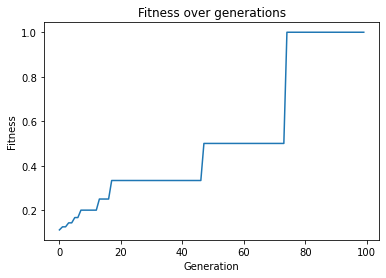

In [55]:
# Plot fitness values
plt.plot(plot_data)
plt.title("Fitness over generations")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.show()